# Final Project - Baseball Analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

trajectoryDifference: 2.042055747113049, finalPositionDifference: 0.3659159893485389


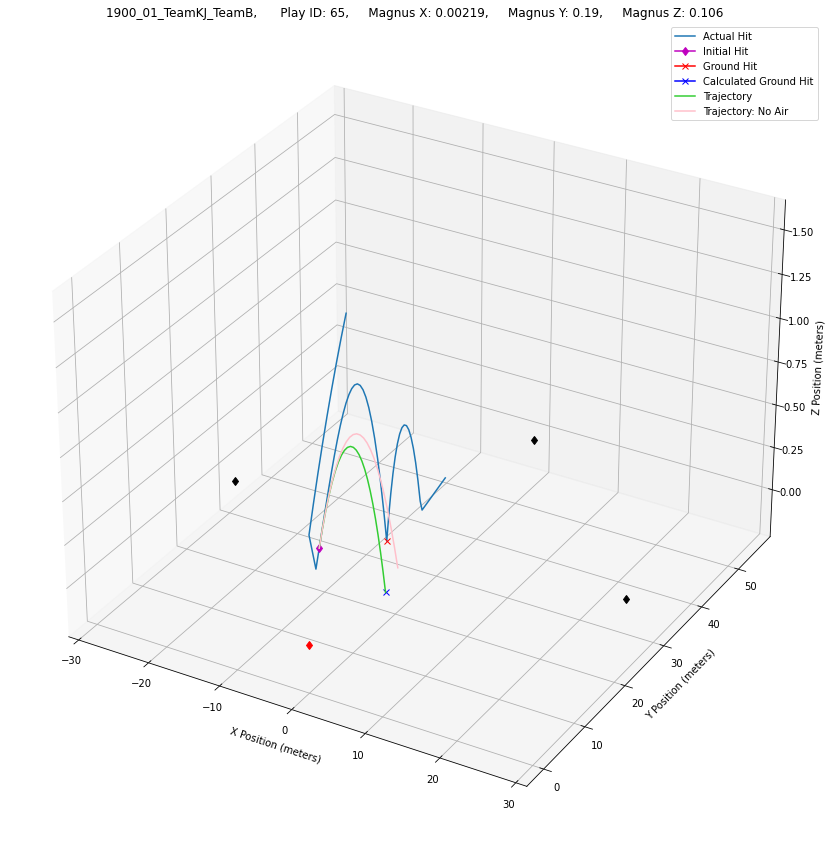

trajectoryDifference: 4.062565079050912, finalPositionDifference: 1.1053126015907284


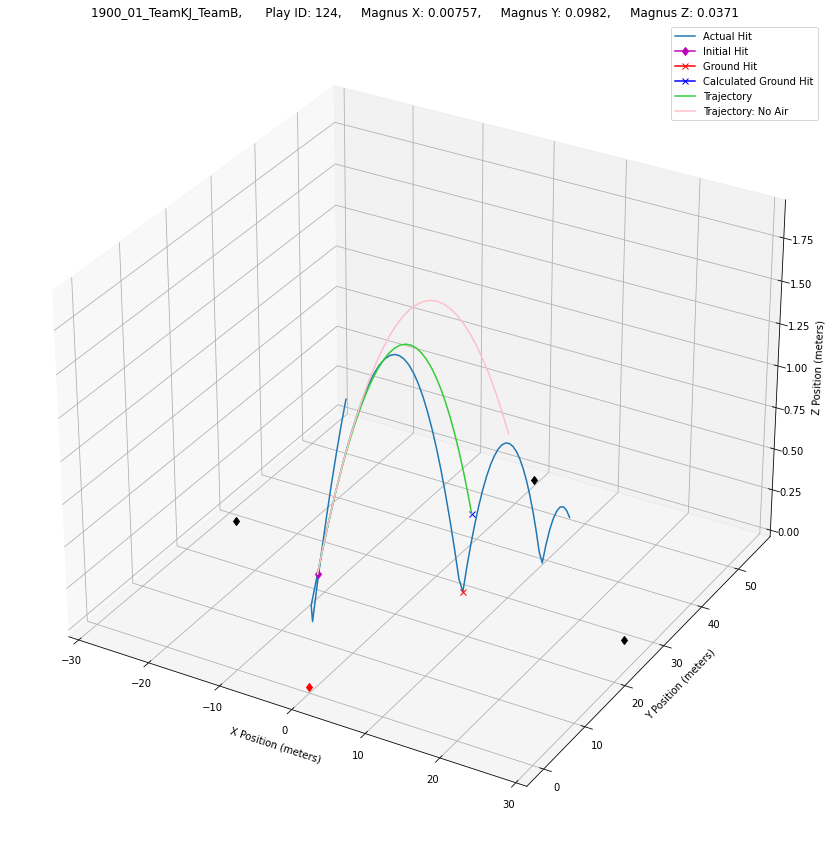

trajectoryDifference: 3.533483734209273, finalPositionDifference: 1.9742330373630865


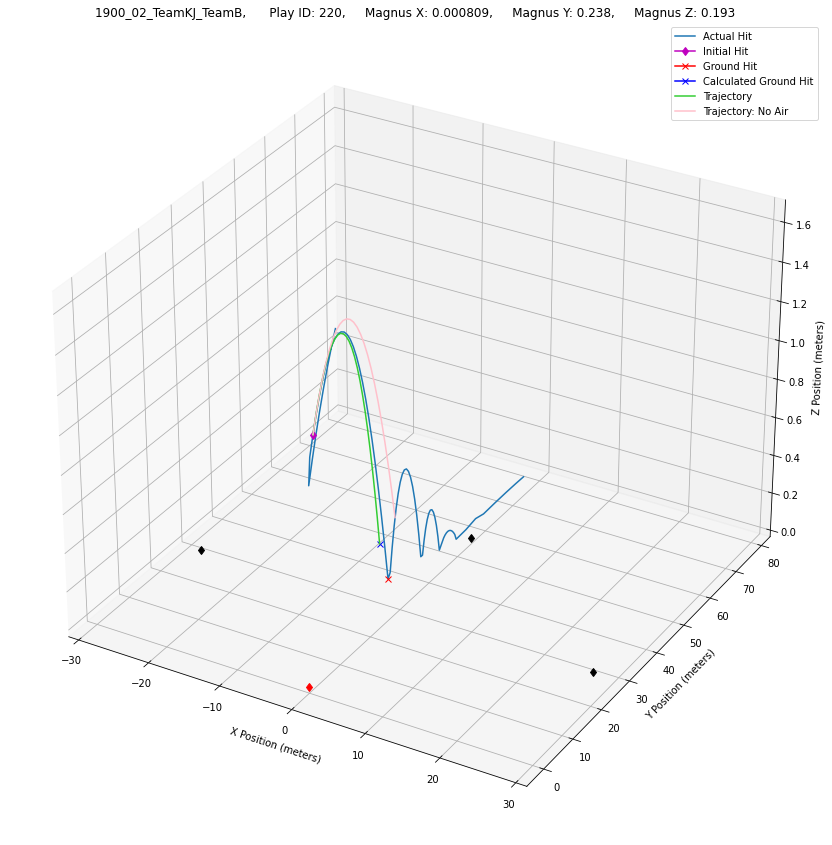

trajectoryDifference: 3.432030375282748, finalPositionDifference: 1.169034909541621


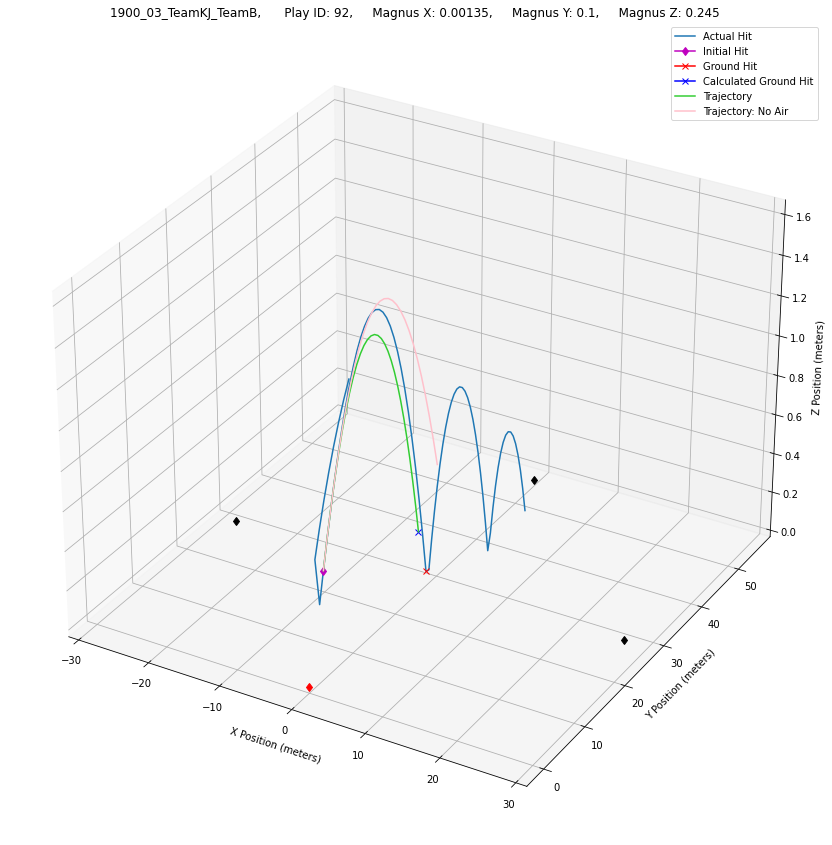

trajectoryDifference: 2.018191835152283, finalPositionDifference: 0.5586243494469209


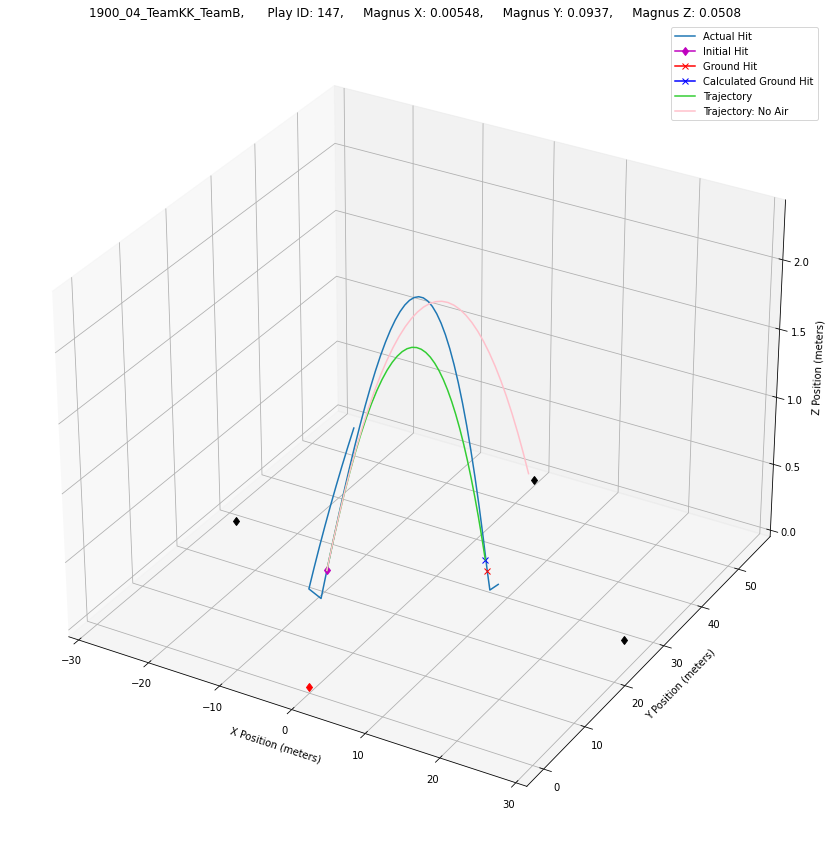

trajectoryDifference: 4.533266136581115, finalPositionDifference: 1.6982437243867265


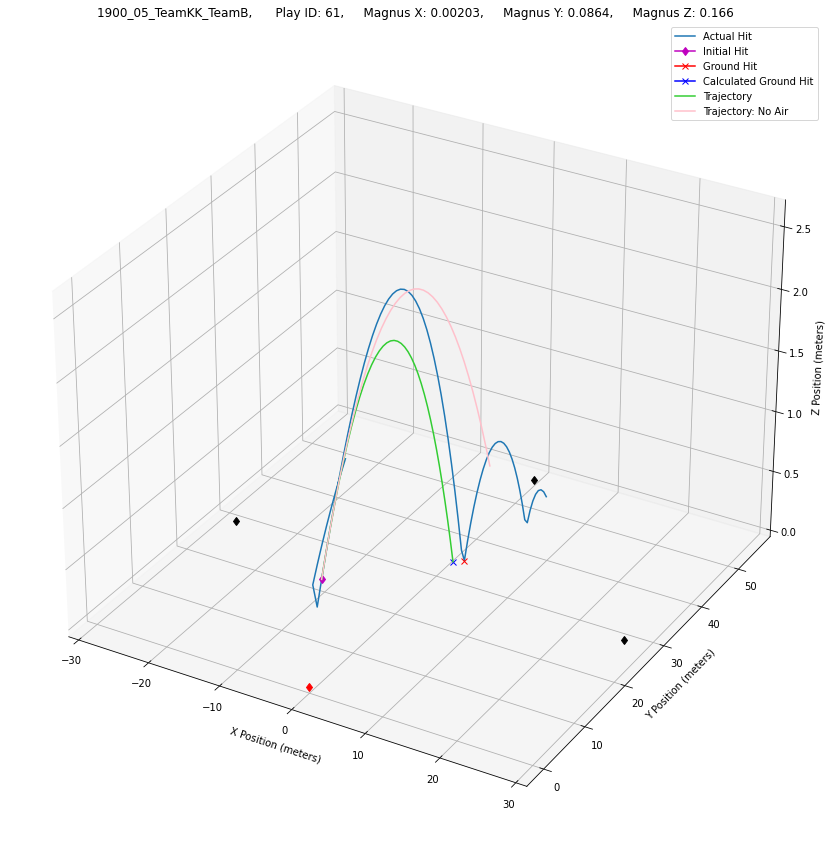

trajectoryDifference: 6.174285266357193, finalPositionDifference: 1.6690212734856218


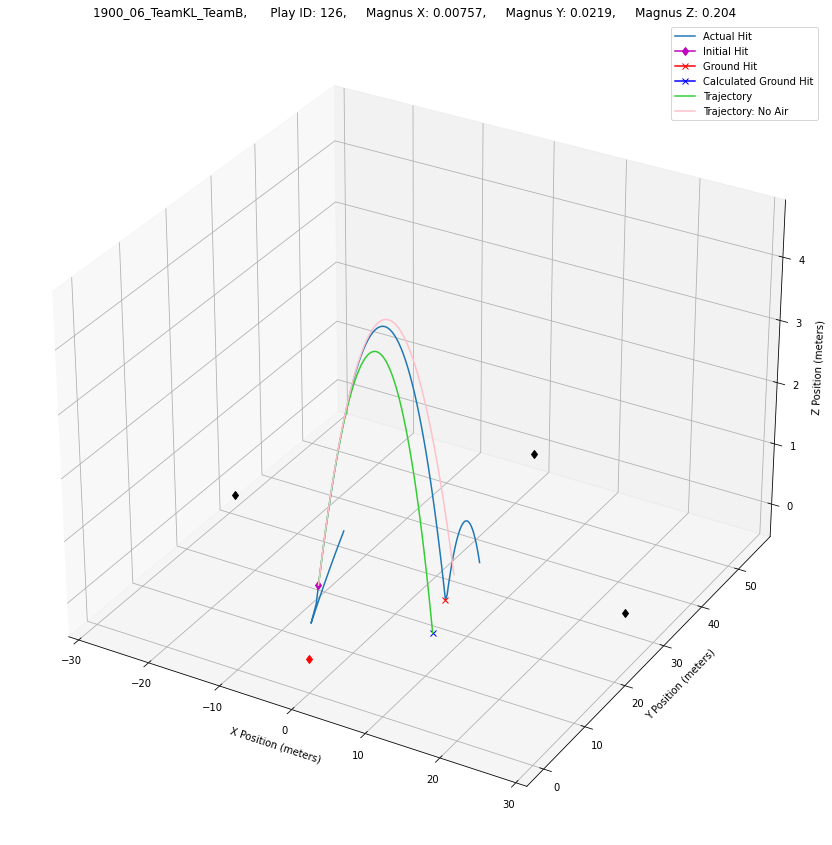

trajectoryDifference: 5.793340519077997, finalPositionDifference: 1.5419867437505967


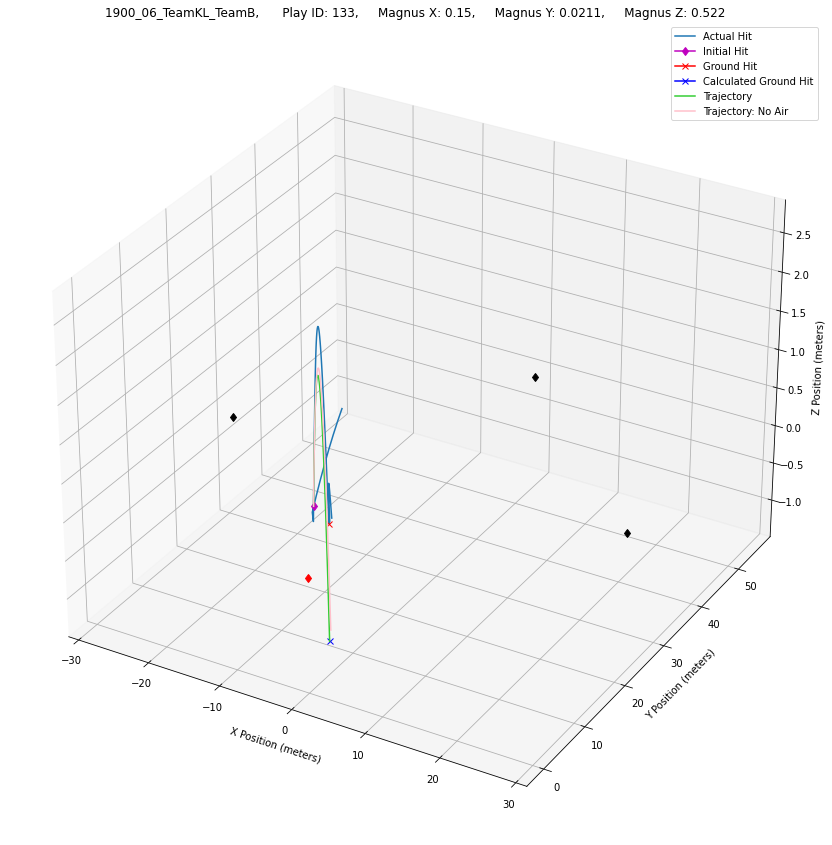

trajectoryDifference: 3.820259559468977, finalPositionDifference: 0.977903334013658


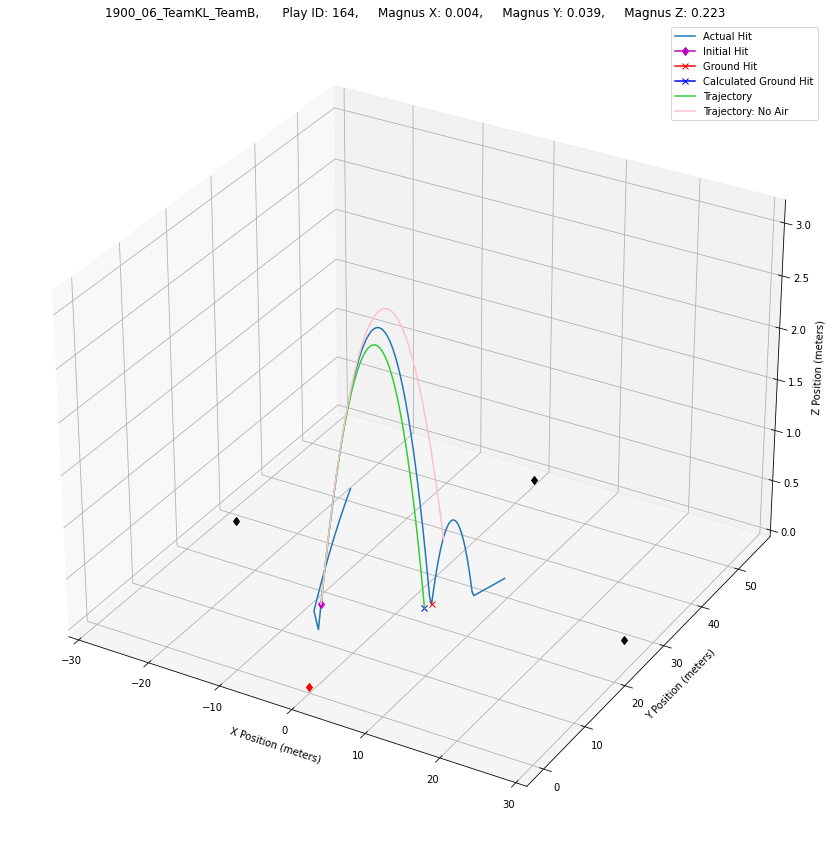

trajectoryDifference: 3.5104175622430165, finalPositionDifference: 1.7554291868285843


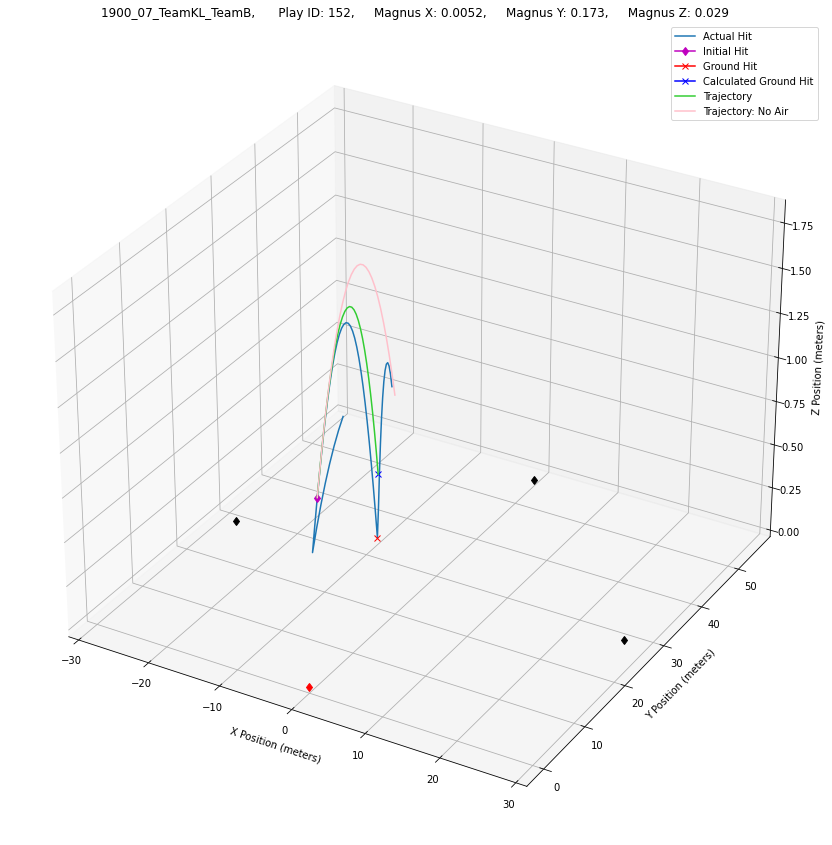

trajectoryDifference: 3.8309817008484632, finalPositionDifference: 1.0104501556816148


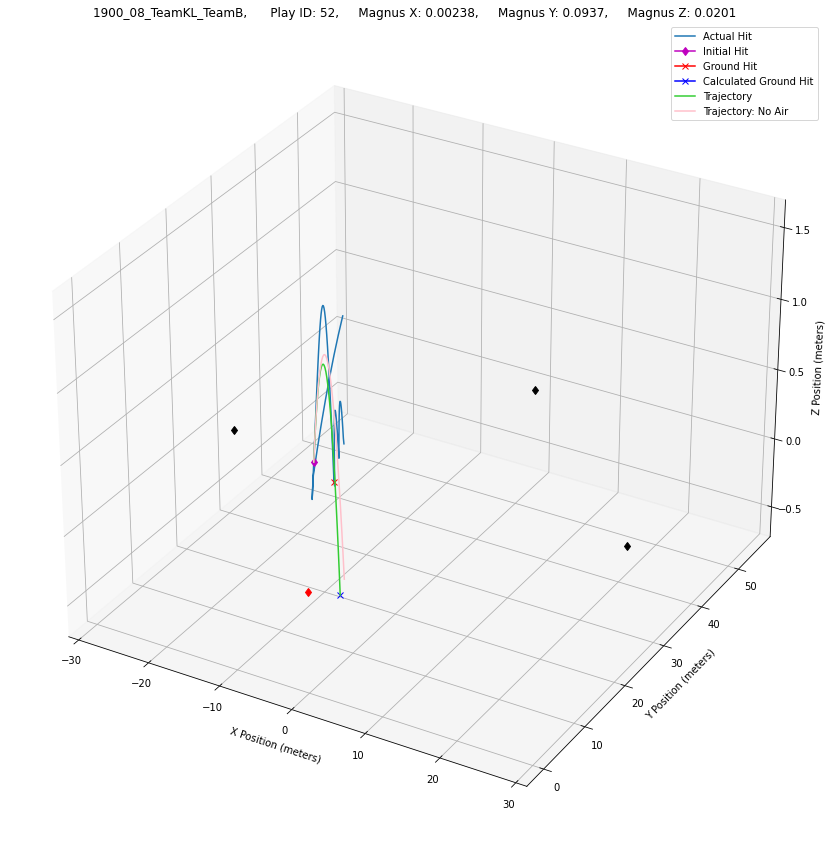

trajectoryDifference: 4.970570340747808, finalPositionDifference: 1.2446064940529058


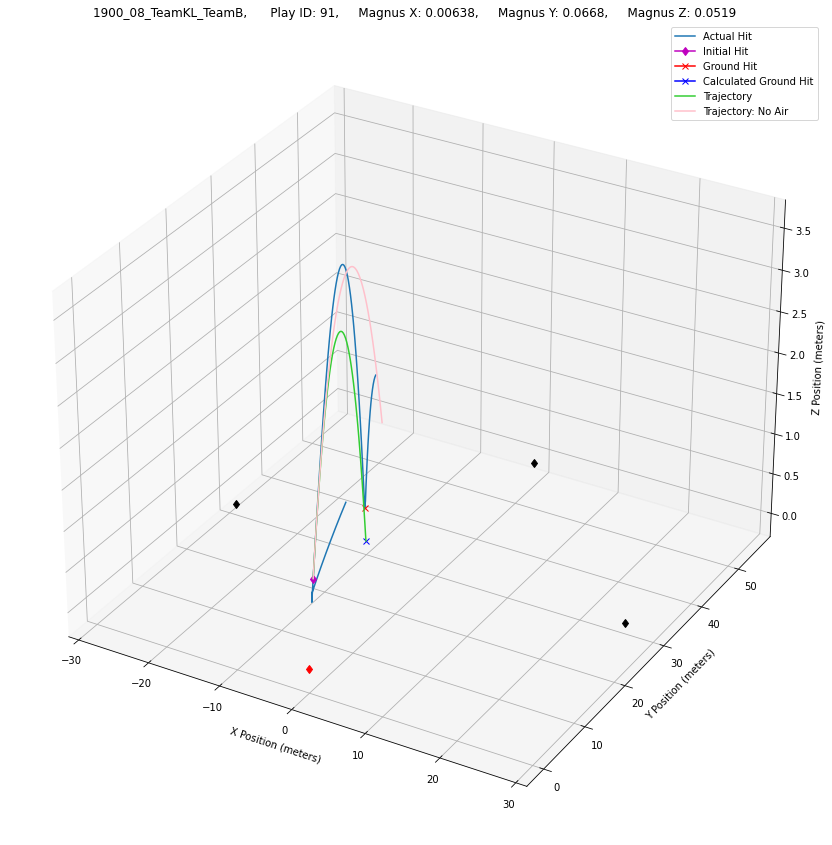

trajectoryDifference: 2.572858581255921, finalPositionDifference: 0.8259142872423307


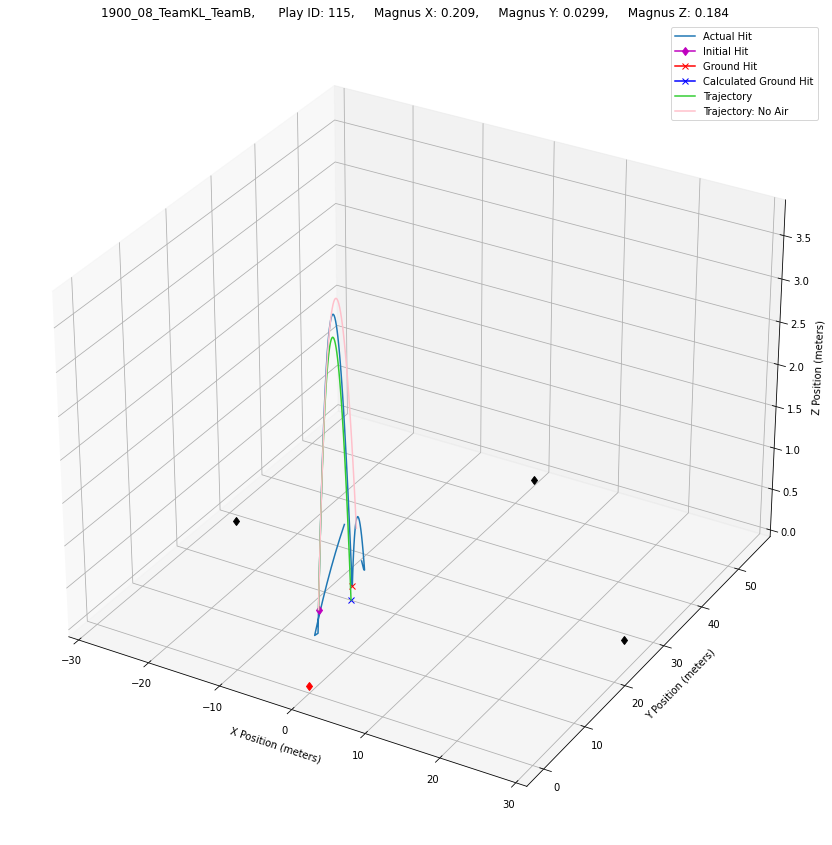

trajectoryDifference: 5.3166395346748025, finalPositionDifference: 1.5503464828508209


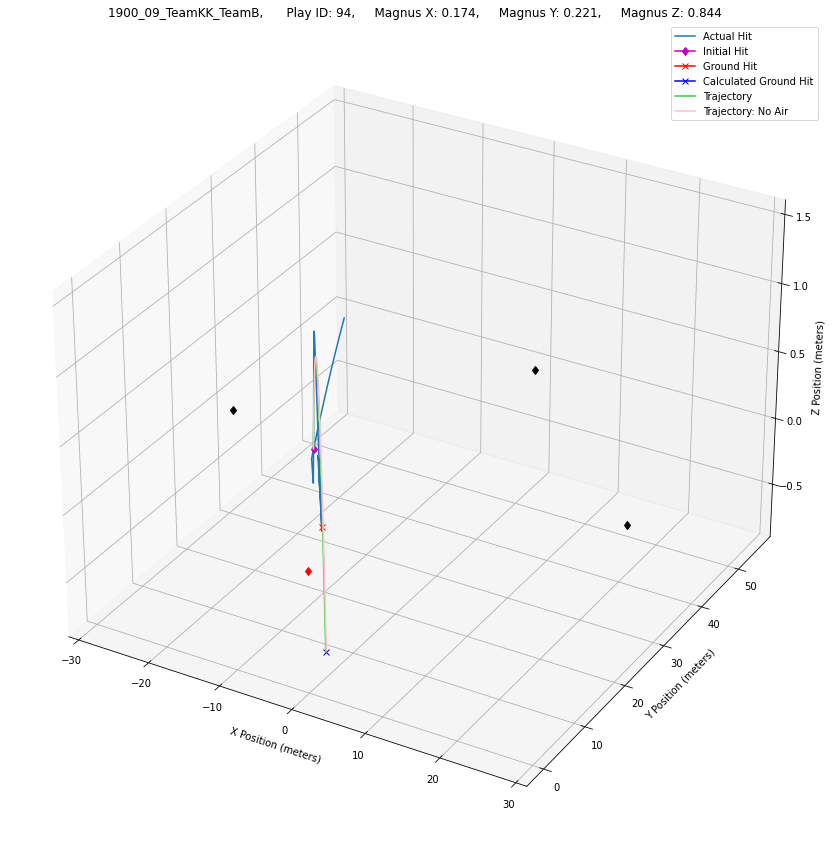

trajectoryDifference: 2.426288476097549, finalPositionDifference: 1.664800329350852


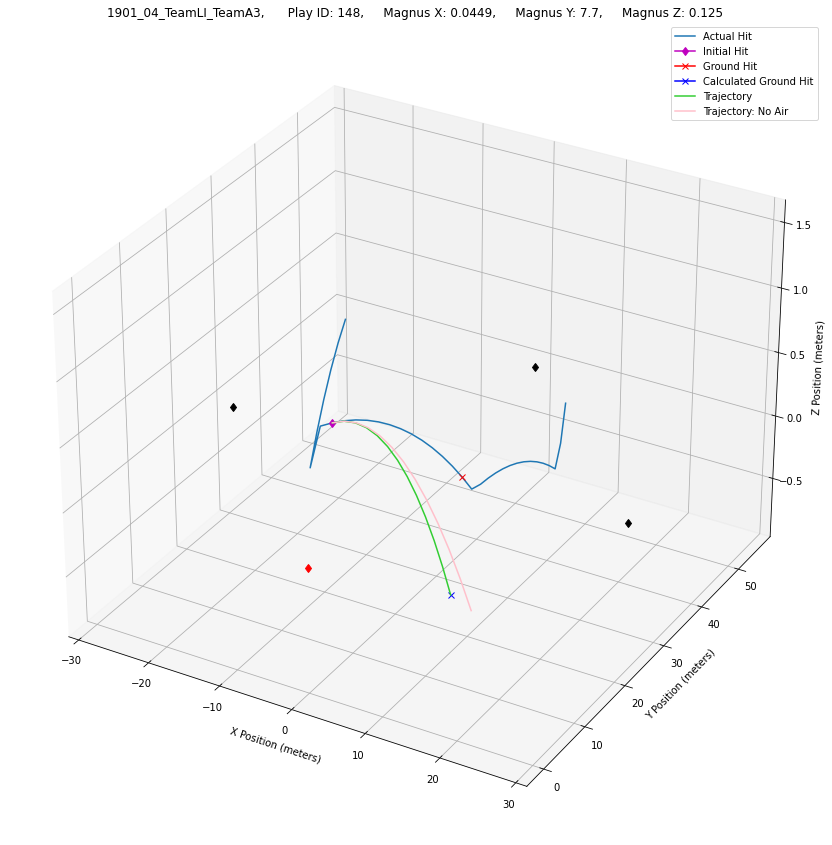

trajectoryDifference: 0.7052201250084551, finalPositionDifference: 0.4351579809578019


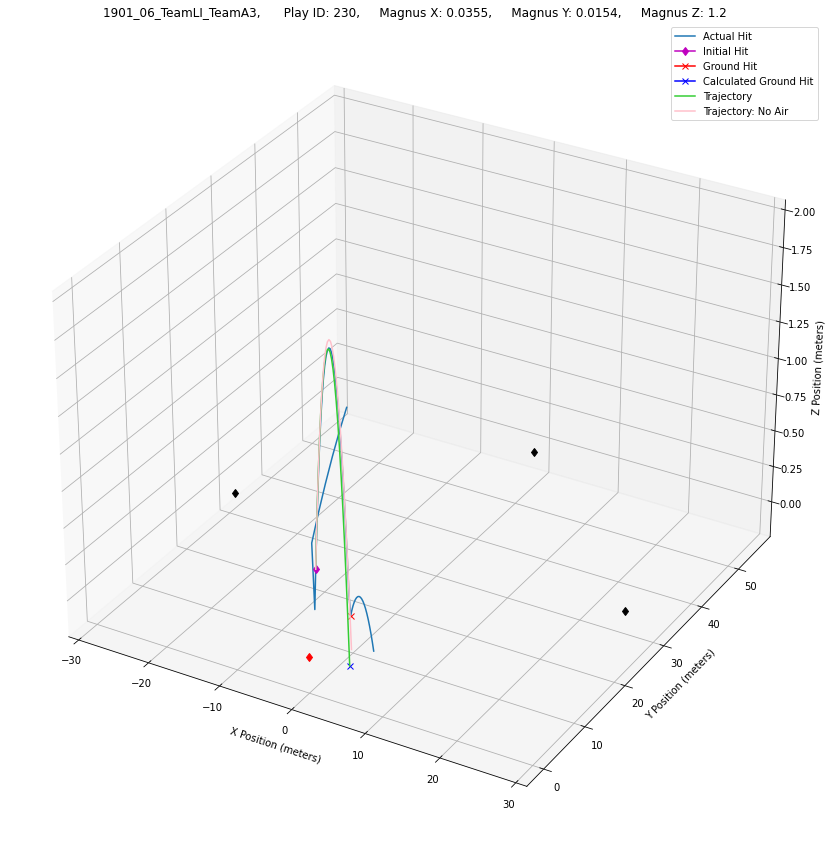

trajectoryDifference: 1.376652738062113, finalPositionDifference: 0.7289901748246396


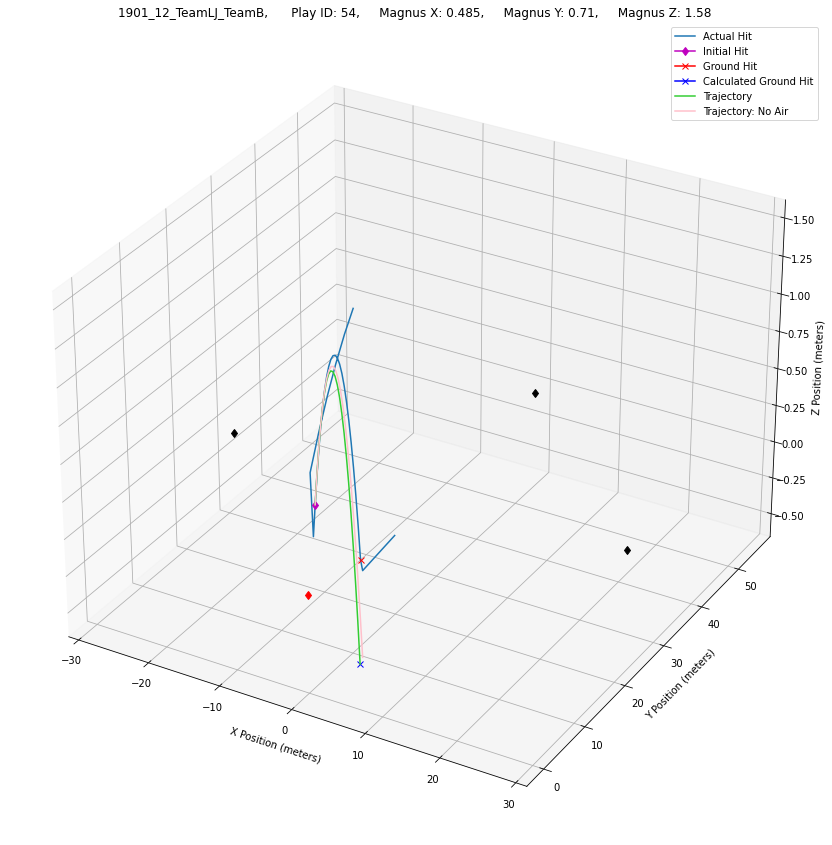

trajectoryDifference: 0.0, finalPositionDifference: 0.0


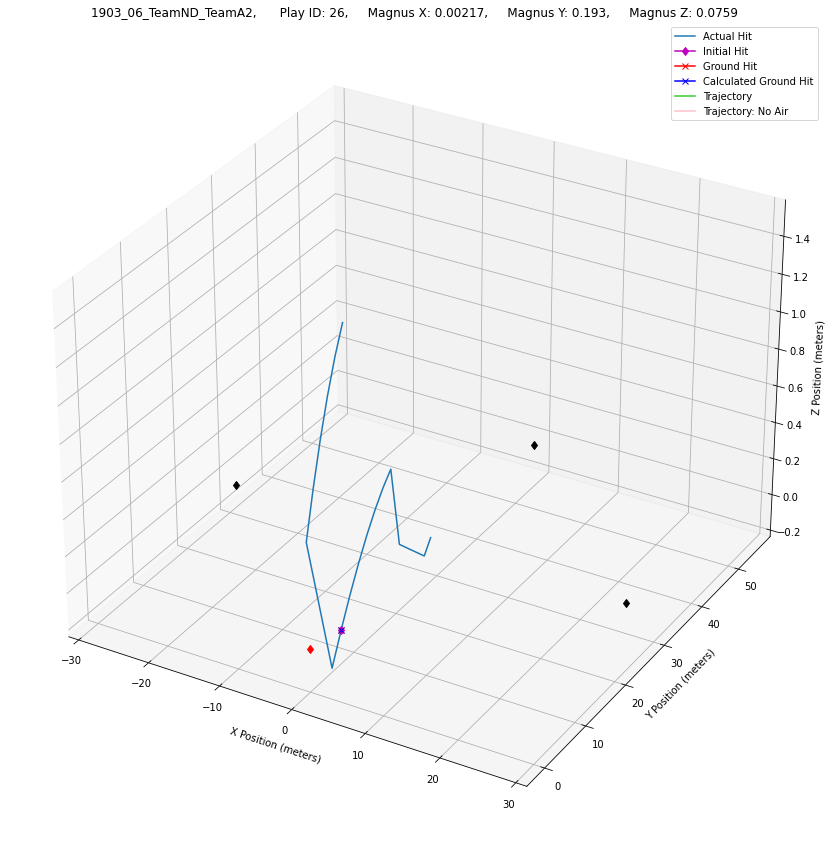

trajectoryDifference: 3.004340779917743, finalPositionDifference: 1.2655610721596189


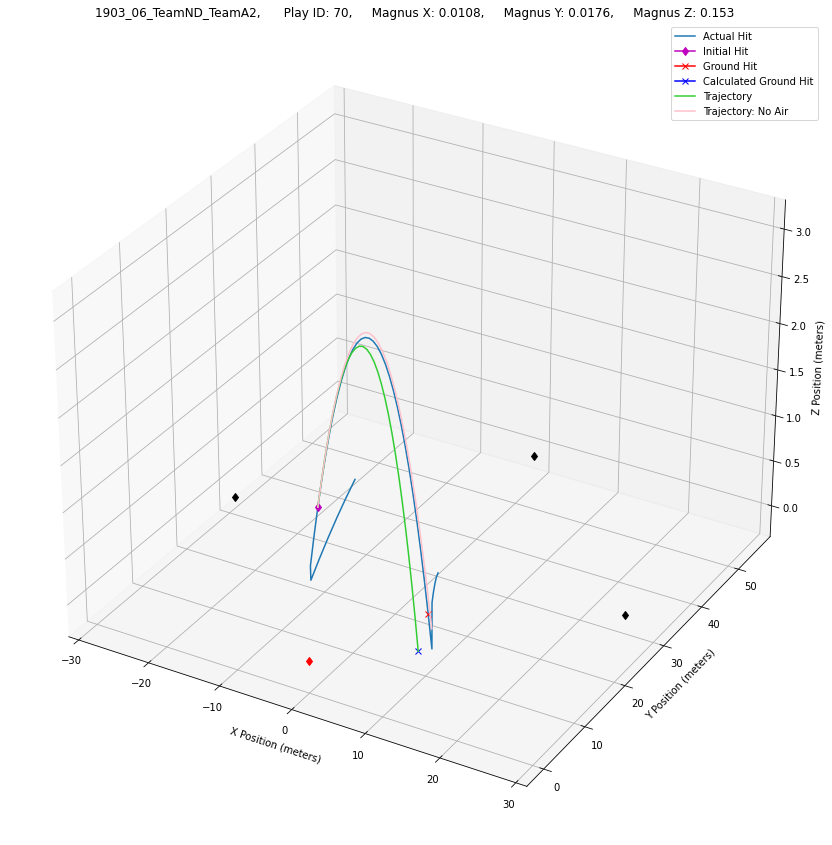

trajectoryDifference: 2.397389933926526, finalPositionDifference: 1.5568705066449313


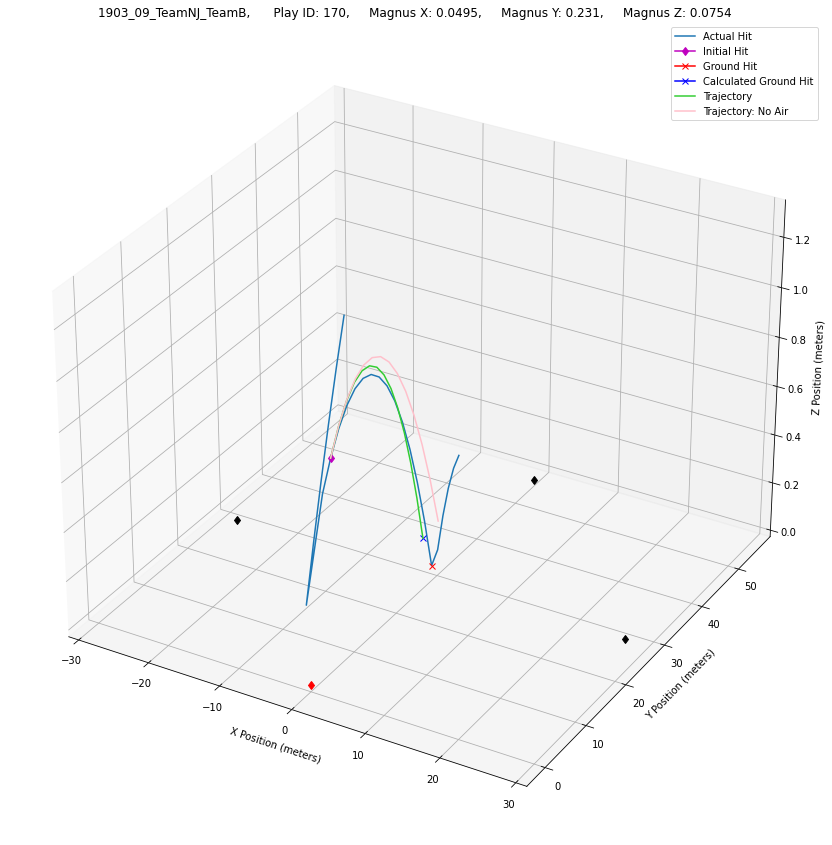

trajectoryDifference: 1.483213083658553, finalPositionDifference: 0.9831287306613061


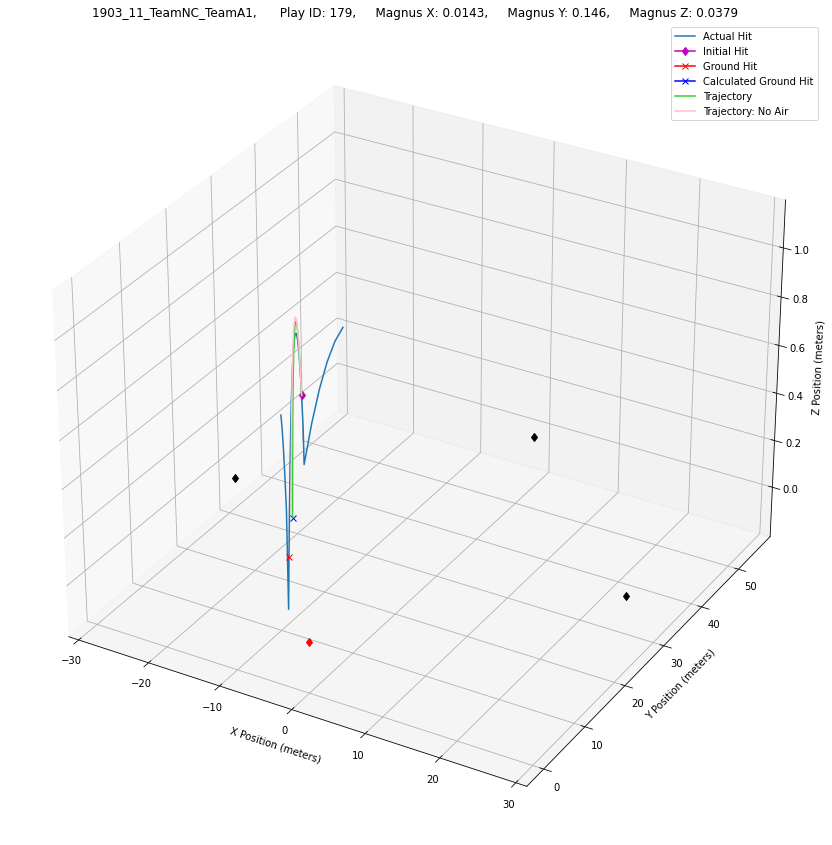

trajectoryDifference: 1.674470880384136, finalPositionDifference: 0.8749231460526598


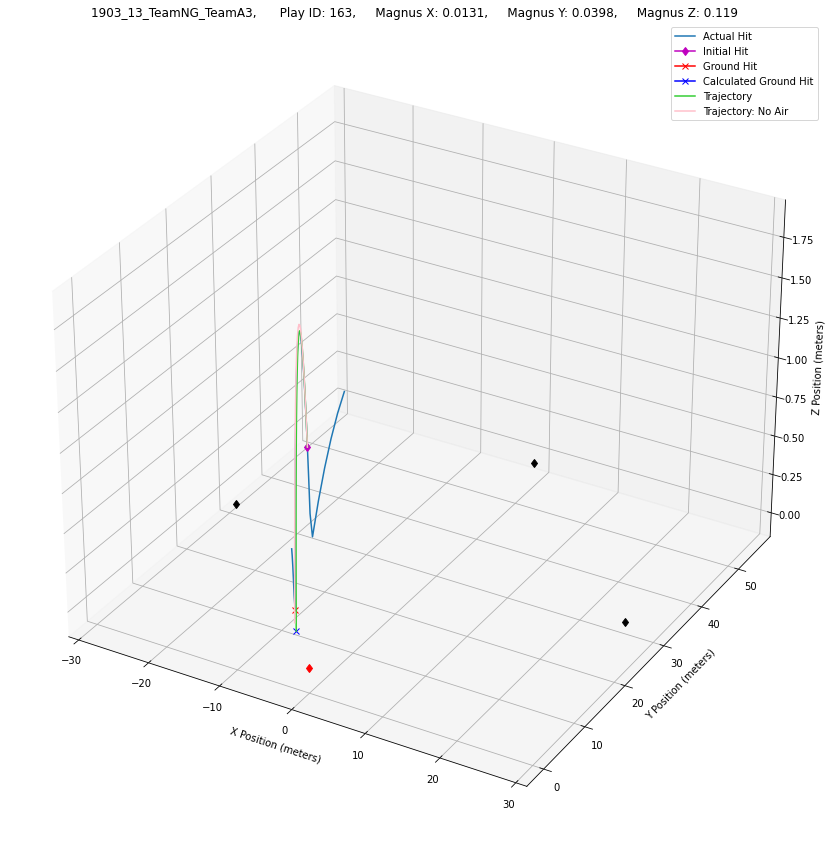

trajectoryDifference: 2.2555248727579142, finalPositionDifference: 1.479004249220367


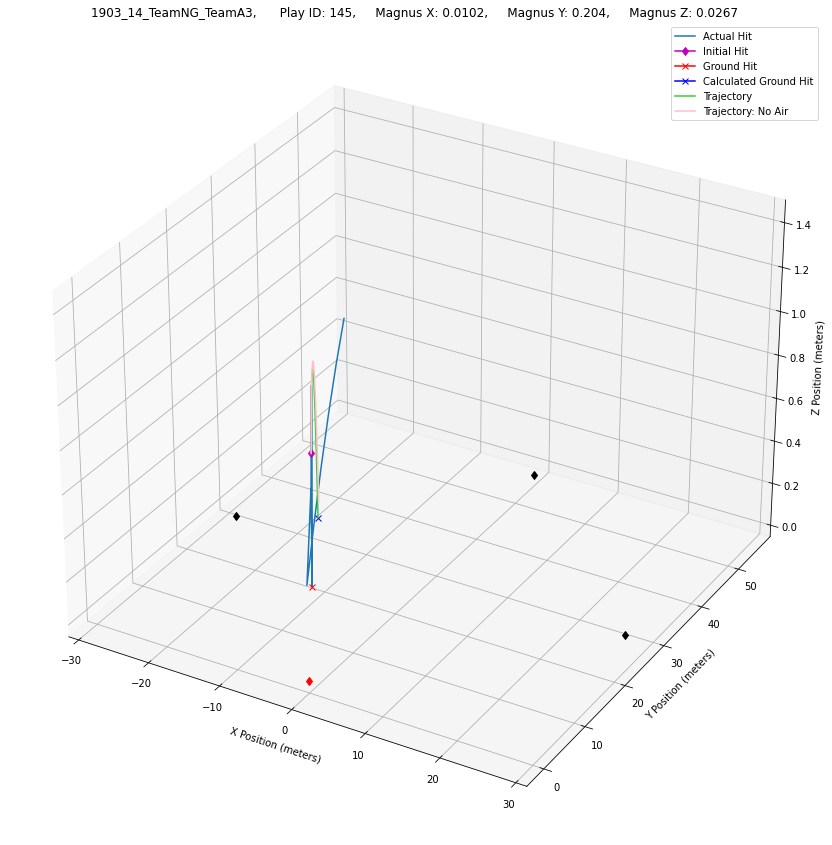

trajectoryDifference: 4.07249903172935, finalPositionDifference: 1.9386328692160157


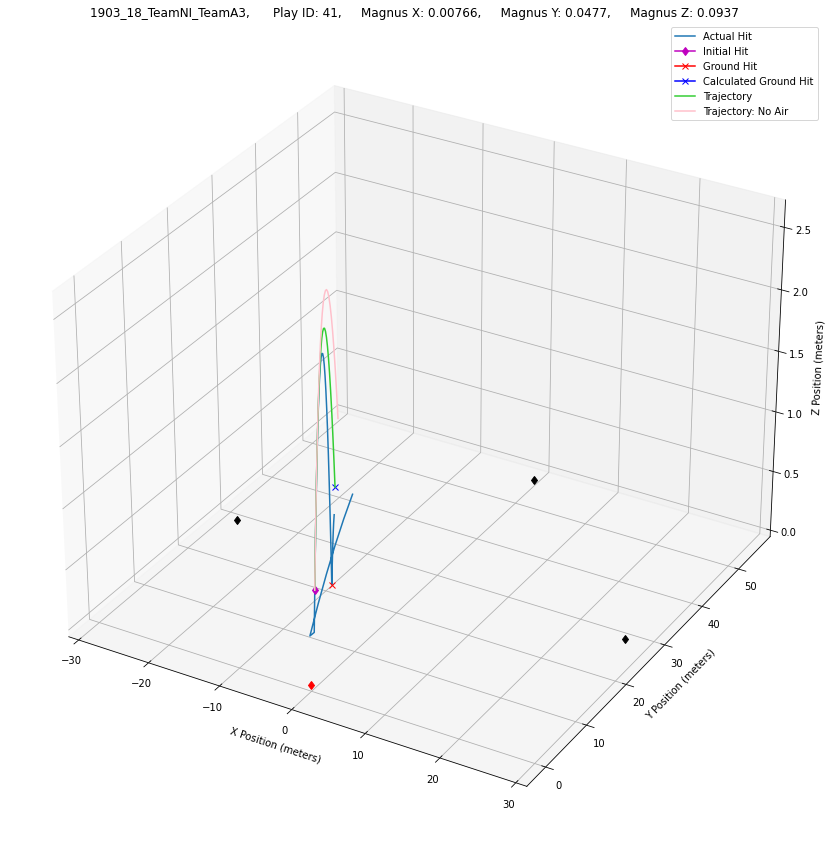

In [3]:
# Final Project
#
# This program will take the input baseball data and analyze it to conclude if there is an
# accurate way of modeling the baseball using the magnus effect.
#
# @author Scott Merkley
# @version April 15, 2022

%reset -f

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')

# Contstants
feetToMeters = 0.3048
g            = 9.81 * 1 # 0.67 makes some of the graphs look REALLY good
fps          = 1e3
ballMass     = 0.145
ballRadius   = 0.075

# Computing Drag
# dragCoeff    = 0.25 # and this at 0.5
rhoAir       = 1.2
# airDrag      = (dragCoeff * rhoAir * np.pi * ballRadius**2) / (2 * ballMass)

# Computing Magnus Force (Making Global Variables)
realMagnusX = 0
realMagnusY = 0
realMagnusZ = 0


# Import the data from the file
data = pd.read_csv('fly_ball_ball_positions.dat', low_memory = False)

# Converting the positions to meters
data['ball_position_x'] = data['ball_position_x'] * feetToMeters
data['ball_position_y'] = data['ball_position_y'] * feetToMeters
data['ball_position_z'] = data['ball_position_z'] * feetToMeters

# Creating "delta" position columns
data['delta_x'] = -(data['ball_position_x'].shift(1) - data['ball_position_x'])
data['delta_y'] = -(data['ball_position_y'].shift(1) - data['ball_position_y'])
data['delta_z'] = -(data['ball_position_z'].shift(1) - data['ball_position_z'])
data['delta_t'] = -(data['timestamp'].shift(1) - data['timestamp'])

# Creating velocity columns, then setting all overlapping velocities to 0
threshold = 50
data['ball_velocity_x'] = data['delta_x'] / data['delta_t'] * fps
data['ball_velocity_x'] = np.where((data['ball_velocity_x'] > threshold) | (data['ball_velocity_x'] < -threshold), 0, data['ball_velocity_x'])
data['ball_velocity_y'] = data['delta_y'] / data['delta_t'] * fps
data['ball_velocity_y'] = np.where((data['ball_velocity_y'] > threshold) | (data['ball_velocity_y'] < -threshold), 0, data['ball_velocity_y'])
data['ball_velocity_z'] = data['delta_z'] / data['delta_t'] * fps
data['ball_velocity_z'] = np.where((data['ball_velocity_z'] > threshold) | (data['ball_velocity_z'] < -threshold), 0, data['ball_velocity_z'])

# Creating "delta" velocity columns
data['delta_vx'] = -(data['ball_velocity_x'].shift(1) - data['ball_velocity_x'])
data['delta_vy'] = -(data['ball_velocity_y'].shift(1) - data['ball_velocity_y'])
data['delta_vz'] = -(data['ball_velocity_z'].shift(1) - data['ball_velocity_z'])

# Creating acceleration columns, then setting all overlapping accelerations to 0
data['ball_acceleration_x'] = data['delta_vx'] / data['delta_t'] * fps
data['ball_acceleration_x'] = np.where((data['ball_acceleration_x'] > threshold) | (data['ball_acceleration_x'] < -threshold), 0, data['ball_acceleration_x'])
data['ball_acceleration_y'] = data['delta_vy'] / data['delta_t'] * fps
data['ball_acceleration_y'] = np.where((data['ball_acceleration_y'] > threshold) | (data['ball_acceleration_y'] < -threshold), 0, data['ball_acceleration_y'])
data['ball_acceleration_z'] = data['delta_vy'] / data['delta_t'] * fps
data['ball_acceleration_z'] = np.where((data['ball_acceleration_z'] > threshold) | (data['ball_acceleration_z'] < -threshold), 0, data['ball_acceleration_z'])

# Creating theta and phi columns
data['ball_theta'] = np.arctan(data['delta_y'] / data['delta_x'])
data['ball_phi']   = np.arctan(data['delta_z'] / data['delta_x'])


# Setting up an array of all the Play ID's per Game
games = data.groupby(['game_str'])['play_id'].unique().reset_index()


# Given a specified game name, play ID, and plot method will plot the game along with a 
# two calculated trajectories, one with air resistance and Magnus force, other with no
# air resistance or Magnus force
#
# @param gameName   - name of the game to plot, given as a string
# @param playID     - ID of the game to plot, given as a integer
# @param plotMethod - axes to be plotted, given as a string (ie. xy, yz, 3D, vx, ax, etc.)
# @return           - plot printed to the console
def plotGame(gameName, playID, plotMethod):
    gameData = data[(data['game_str'] == gameName) & (data['play_id'] == playID)]
    pos = 90 * feetToMeters  # Diamond position in meters
    
    # Trying to find the first non negative point but sometimes all values are negative..
    initialHitIndex = gameData['ball_position_y'].abs().idxmin() + 2
    
    # Create a new data frame to return to the user with the same columns as before so that you can test them against each other
    ballHitsGround  = gameData[gameData['ball_position_z'].abs() < 0.2].index.values.astype(int)[0]
    
    trajectory, trajectoryNoAir, realMagnusX, realMagnusY, realMagnusZ = getTrajectory(gameData, initialHitIndex, ballHitsGround)
    trajectoryDF = pd.DataFrame(trajectory, columns = ['ball_position_x', 'ball_velocity_x', 'ball_position_y', 'ball_velocity_y', 'ball_position_z', 'ball_velocity_z'])
    
    trajectoryDifference = getTrajectoryDifference(gameData, trajectoryDF, initialHitIndex, ballHitsGround)
    finalPositionDifference = getFinalPositionDifference(gameData['ball_position_x'][ballHitsGround], gameData['ball_position_y'][ballHitsGround], gameData['ball_position_z'][ballHitsGround],\
                                         trajectoryDF['ball_position_x'].iloc[-1], trajectoryDF['ball_position_y'].iloc[-1], trajectoryDF['ball_position_z'].iloc[-1])
    
    # If the total difference between the trajectory and the actual hit is less than 20 plot the hit
    if((abs(trajectoryDifference) < 20) & (finalPositionDifference < 2)):
        
        print(f'trajectoryDifference: {trajectoryDifference}, finalPositionDifference: {finalPositionDifference}')
        
        # Trajectory Colors
        trajectoryColor = 'limegreen'
        trajectoryNoAirColor = 'pink'
    
        if(plotMethod == 'xy'):
            # Plot the X vs Y data
            # Make a nice looking Baseball Diamond Plot
            plt.figure(figsize = (15, 15))
            plt.title(f'{gameName},      Play ID: {playID},     Magnus X: {realMagnusX:0.3},     Magnus Y: {realMagnusY:0.3}')
            plt.xlabel('X Position (meters)')
            plt.ylabel('Y Position (meters)')
            plt.plot(0, 0, 'kd', -pos, pos, 'kd', pos, pos, 'kd', 0, 2 * pos, 'kd')
            plt.plot(gameData['ball_position_x'], gameData['ball_position_y'], 'b-', label = 'Actual Hit')
            plt.plot(gameData['ball_position_x'][initialHitIndex], gameData['ball_position_y'][initialHitIndex], 'rd', label = 'initial hit')
            plt.plot(gameData['ball_position_x'][ballHitsGround], gameData['ball_position_y'][ballHitsGround], c = 'r', marker ='x', label = 'Ground Hit')
            plt.plot(trajectoryDF['ball_position_x'].iloc[-1], trajectoryDF['ball_position_y'].iloc[-1], c = 'b', marker ='x', label = 'Calculated Ground Hit')
            plt.plot(trajectory[:, 0], trajectory[:, 2], trajectoryColor, label = 'Trajectory')
            plt.plot(trajectoryNoAir[:, 0], trajectoryNoAir[:, 2], trajectoryNoAirColor, label = 'Trajectory: No Air')
            plt.legend()
            plt.grid()
            plt.show()

        if(plotMethod == 'xz'):
            # Plot the X vs Z data
            plt.figure(figsize = (20, 15))
            plt.title(f'{gameName},      Play ID: {playID},     Magnus X: {realMagnusX},     Magnus Z: {realMagnusZ}')
            plt.xlabel('X Position (meters)')
            plt.ylabel('Z Position (meters)')
            plt.plot(gameData['ball_position_x'], gameData['ball_position_z'], 'b-', label = 'Actual Hit')
            plt.plot(gameData['ball_position_x'][initialHitIndex], gameData['ball_position_z'][initialHitIndex], 'rd', label = 'initial hit')
            plt.plot(gameData['ball_position_x'][ballHitsGround], gameData['ball_position_z'][ballHitsGround], c = 'r', marker ='x', label = 'Ground Hit')
            plt.plot(trajectoryDF['ball_position_x'].iloc[-1], trajectoryDF['ball_position_z'].iloc[-1], c = 'b', marker ='x', label = 'Calculated Ground Hit')
            plt.plot(trajectory[:, 0], trajectory[:, 4], trajectoryColor, label = 'Trajectory')
            plt.plot(trajectoryNoAir[:, 0], trajectoryNoAir[:, 4], trajectoryNoAirColor, label = 'Trajectory: No Air')
            plt.legend()
            plt.grid()
            plt.show()

        if(plotMethod == 'yz'):
            # Plot the Y vs Z data
            plt.figure(figsize = (20, 15))
            plt.title(f'{gameName},      Play ID: {playID},     Magnus Y: {realMagnusY},     Magnus Z: {realMagnusZ}')
            plt.xlabel('Y Position (meters)')
            plt.ylabel('Z Position (meters)')
            plt.plot(gameData['ball_position_y'], gameData['ball_position_z'], 'b-', label = 'Actual Hit')
            plt.plot(gameData['ball_position_y'][initialHitIndex], gameData['ball_position_z'][initialHitIndex], 'rd', label = 'initial hit')
            plt.plot(gameData['ball_position_y'][ballHitsGround], gameData['ball_position_z'][ballHitsGround], c = 'r', marker ='x', label = 'Ground Hit')
            plt.plot(trajectoryDF['ball_position_y'].iloc[-1], trajectoryDF['ball_position_z'].iloc[-1], c = 'b', marker ='x', label = 'Calculated Ground Hit')
            plt.plot(trajectory[:, 2], trajectory[:, 4], trajectoryColor, label = 'Trajectory')
            plt.plot(trajectoryNoAir[:, 2], trajectoryNoAir[:, 4], trajectoryNoAirColor, label = 'Trajectory: No Air')
            plt.legend()
            plt.grid()
            plt.show()

        if(plotMethod == '3D'):
            # Plot the 3D data
            plt.figure(figsize = (15, 15))
            ax = plt.axes(projection='3d')
            ax.set_title(f'{gameName},      Play ID: {playID},     Magnus X: {realMagnusX:0.3},     Magnus Y: {realMagnusY:0.3},     Magnus Z: {realMagnusZ:0.3}')
            ax.plot3D(0, 0, 0, c = 'r', marker = 'd')
            ax.plot3D(-pos, pos, 0, c = 'k', marker = 'd')
            ax.plot3D(pos, pos, 0, c = 'k', marker = 'd')
            ax.plot3D(0, 2 * pos, 0, c = 'k', marker = 'd')
            ax.plot3D(gameData['ball_position_x'], gameData['ball_position_y'], gameData['ball_position_z'], label = 'Actual Hit')
            ax.plot3D(gameData['ball_position_x'][initialHitIndex], gameData['ball_position_y'][initialHitIndex], gameData['ball_position_z'][initialHitIndex], c = 'm', marker ='d', label = 'Initial Hit')
            ax.plot3D(gameData['ball_position_x'][ballHitsGround], gameData['ball_position_y'][ballHitsGround], gameData['ball_position_z'][ballHitsGround], c = 'r', marker ='x', label = 'Ground Hit')
            ax.plot3D(trajectoryDF['ball_position_x'].iloc[-1], trajectoryDF['ball_position_y'].iloc[-1], trajectoryDF['ball_position_z'].iloc[-1], c = 'b', marker ='x', label = 'Calculated Ground Hit')
            ax.plot3D(trajectory[:, 0], trajectory[:, 2], trajectory[:, 4], trajectoryColor, label = 'Trajectory')
            plt.plot(trajectoryNoAir[:, 0], trajectoryNoAir[:, 2], trajectoryNoAir[:, 4], trajectoryNoAirColor, label = 'Trajectory: No Air')
            ax.set_xlabel('X Position (meters)')
            ax.set_ylabel('Y Position (meters)')
            ax.set_zlabel('Z Position (meters)')
            ax.legend()
            plt.show()

        if(plotMethod == 'vx'):
            t = np.linspace(0, len(gameData['ball_velocity_x']) / 60, len(gameData['ball_velocity_x']))
            plt.figure(figsize = (15, 15))
            plt.title(f'{gameName},      Play ID: {playID}')
            plt.xlabel('time (sec)')
            plt.ylabel('x velocity (m/s)')
            plt.plot(t, gameData['ball_velocity_x'])
            plt.show()

        if(plotMethod == 'vy'):
            t = np.linspace(0, len(gameData['ball_velocity_y']) / 60, len(gameData['ball_velocity_y']))
            plt.figure(figsize = (15, 15))
            plt.title(f'{gameName},      Play ID: {playID}')
            plt.xlabel('time (sec)')
            plt.ylabel('y velocity (m/s)')
            plt.plot(t, gameData['ball_velocity_y'])
            plt.show()

        if(plotMethod == 'vz'):
            t = np.linspace(0, len(gameData['ball_velocity_z']) / 60, len(gameData['ball_velocity_z']))
            plt.figure(figsize = (15, 15))
            plt.title(f'{gameName},      Play ID: {playID}')
            plt.xlabel('time (sec)')
            plt.ylabel('z velocity (m/s)')
            plt.plot(t, gameData['ball_velocity_z'])
            plt.show()

        if(plotMethod == 'ax'):
            t = np.linspace(0, len(gameData['ball_acceleration_x']) / 60, len(gameData['ball_acceleration_x']))
            plt.figure(figsize = (15, 15))
            plt.title(f'{gameName},      Play ID: {playID}')
            plt.xlabel('time (sec)')
            plt.ylabel('x acceleration (m/s^2)')
            plt.plot(t, gameData['ball_acceleration_x'])
            plt.show()

        if(plotMethod == 'ay'):
            t = np.linspace(0, len(gameData['ball_acceleration_y']) / 60, len(gameData['ball_acceleration_y']))
            plt.figure(figsize = (15, 15))
            plt.title(f'{gameName},      Play ID: {playID}')
            plt.xlabel('time (sec)')
            plt.ylabel('y acceleration (m/s^2)')
            plt.plot(t, gameData['ball_acceleration_y'])
            plt.show()

        if(plotMethod == 'az'):
            t = np.linspace(0, len(gameData['ball_acceleration_z']) / 60, len(gameData['ball_acceleration_z']))
            plt.figure(figsize = (15, 15))
            plt.title(f'{gameName},      Play ID: {playID}')
            plt.xlabel('time (sec)')
            plt.ylabel('z acceleration (m/s^2)')
            plt.plot(t, gameData['ball_acceleration_z'])
            plt.show()
        

# This method calculates the difference between the given trajectory and the game data, returning
# a number corresponding to the fit of the trajectory. The lower the number, the closer the fit.
#
# @param gameData                   - the game data to be used, given as a pandas dataframe with specific columns
# @param trajectory                 - the trajectory to find the difference between, given as a odeint solution
# @param initialHitIndex            - the index of the first hit to be started at, given as an integer
# @param ballHitsGround             - the index when the ball hits the ground, given as an integer
# @return totalTrajectoryDifference - the difference between the hit and trajectory, given as an integer
def getTrajectoryDifference(gameData, trajectoryDF, initialHitIndex, ballHitsGround):
    
    # This calculates how close the trajectory is to the actual hit
    trajectoryDifferenceX = np.sum((data['ball_position_x'].iloc[initialHitIndex : ballHitsGround].reset_index(drop = True) - trajectoryDF['ball_position_x'].iloc[0 : ballHitsGround - initialHitIndex])**2)
    trajectoryDifferenceY = np.sum((data['ball_position_y'].iloc[initialHitIndex : ballHitsGround].reset_index(drop = True) - trajectoryDF['ball_position_y'].iloc[0 : ballHitsGround - initialHitIndex])**2)
    trajectoryDifferenceZ = np.sum((data['ball_position_z'].iloc[initialHitIndex : ballHitsGround].reset_index(drop = True) - trajectoryDF['ball_position_z'].iloc[0 : ballHitsGround - initialHitIndex])**2)
    totalTrajectoryDifference = np.sqrt(trajectoryDifferenceX + trajectoryDifferenceY + trajectoryDifferenceZ)
    
    return totalTrajectoryDifference
        

        
# This method takesn in the game data, intital hit index, and the index of when the ball hits the ground 
# and calculates the trajectory using Scipy's odeint and returns the trajectory along with the calculated magnus
# coefficients.
#
# @param gameData        - the game data to be used, given as a pandas dataframe with specific columns
# @param initialHitIndex - the index of the first hit to be started at, given as an integer
# @param ballHitsGround  - the index when the ball hits the ground, given as an integer
# @return an array with the air resistance trajectory, vacuum trajectory, x magnus coefficient, y magnus coefficient, z magnus coefficient
def getTrajectory(gameData, initialHitIndex, ballHitsGround):
    
    # Create the initial hit array
    initialHit = np.array([gameData['ball_position_x'][initialHitIndex], gameData['ball_velocity_x'][initialHitIndex],\
                           gameData['ball_position_y'][initialHitIndex], gameData['ball_velocity_y'][initialHitIndex],\
                            gameData['ball_position_z'][initialHitIndex], gameData['ball_velocity_z'][initialHitIndex]])

    # Prints the Initial hit information
#     print(f'x: {initialHit[0]:0.3}, vx: {initialHit[1]:0.3}, \ny: {initialHit[2]:0.3}, vy: {initialHit[3]:0.3}, \nz: {initialHit[4]:0.3}, vz: {initialHit[5]:0.3}')
    
    # Wanting to try taking the X and Y magnus effects at when the ball reaches its max height and see if we can get some closer numbers
#     peakHeightIndex = gameData['ball_position_z'].abs().idxmax()
#     peakVelocity = np.linalg.norm(np.array([gameData['ball_velocity_x'][peakHeightIndex], gameData['ball_velocity_y'][peakHeightIndex], gameData['ball_velocity_z'][peakHeightIndex]]))
#     realMagnusX = (gameData['ball_acceleration_x'][peakHeightIndex] + getAirDrag(gameData['ball_velocity_x'][initialHitIndex]) * peakVelocity * gameData['ball_velocity_x'][peakHeightIndex]) / (peakVelocity * gameData['ball_velocity_x'][peakHeightIndex])
#     realMagnusY = (gameData['ball_acceleration_y'][peakHeightIndex] + getAirDrag(gameData['ball_velocity_y'][initialHitIndex]) * peakVelocity * gameData['ball_velocity_y'][peakHeightIndex]) / (peakVelocity * gameData['ball_velocity_y'][peakHeightIndex])
#     realMagnusZ = (gameData['ball_acceleration_z'][peakHeightIndex] + getAirDrag(gameData['ball_velocity_z'][initialHitIndex]) * peakVelocity * gameData['ball_velocity_z'][peakHeightIndex] + g) / (peakVelocity * gameData['ball_velocity_z'][peakHeightIndex])
    
    # Trying to calculate the actual magnus effect on the ball and set the global variable
    initialVelocity = np.linalg.norm(np.array([gameData['ball_velocity_x'][initialHitIndex], gameData['ball_velocity_y'][initialHitIndex], gameData['ball_velocity_z'][initialHitIndex]]))
    realMagnusX = abs((gameData['ball_acceleration_x'][initialHitIndex] + getAirDrag(gameData['ball_velocity_x'][initialHitIndex]) * initialVelocity * gameData['ball_velocity_x'][initialHitIndex]) / (initialVelocity * gameData['ball_velocity_y'][initialHitIndex]))
    realMagnusY = abs((gameData['ball_acceleration_y'][initialHitIndex] + getAirDrag(gameData['ball_velocity_y'][initialHitIndex]) * initialVelocity * gameData['ball_velocity_y'][initialHitIndex]) / (initialVelocity * gameData['ball_velocity_z'][initialHitIndex]))
    realMagnusZ = abs((gameData['ball_acceleration_z'][initialHitIndex] + getAirDrag(gameData['ball_velocity_z'][initialHitIndex]) * initialVelocity * gameData['ball_velocity_z'][initialHitIndex] + g) / (initialVelocity * gameData['ball_velocity_x'][initialHitIndex]))
    
    # Create a time array
    t = np.linspace(0, (gameData['timestamp'][ballHitsGround] - gameData['timestamp'][initialHitIndex]) / fps, ballHitsGround - initialHitIndex + 1)
    
    # Make an odeint solver and plug the initial hit array into it with time
    return np.array([odeint(positionDerivative, initialHit, t), odeint(vacuumPositionDerivative, initialHit, t), realMagnusX, realMagnusY, realMagnusZ], dtype = object)
        

# This method is an air resistance derivative calculator for Scipy's odeint function. It takes in a specified position array s and gives back the 
# derivates of the positions and velocities.
#
# @param s - an array with specified position and velocities (see below)
# @param t - an array of time values to be calculated against
# @return the derivative of the s array
def positionDerivative(s, t):
    # s is packed like:
    #   s[0] = x velocity
    #   s[1] = x acceleration
    #   s[2] = y velocity
    #   s[3] = y acceleration
    #   s[4] = z velocity
    #   s[5] = z acceleration
    
    # Unpack the array
    vx    = s[1]
    ax    = 0
    
    vy    = s[3]
    ay    = 0
    
    vz    = s[5]
    az    = -g
    
    vNow = np.array([vx, vy, vz])
    
    airDrag = getAirDrag(np.linalg.norm(vNow))
    
    axNow = -airDrag * np.linalg.norm(vNow) * vx - realMagnusY * np.linalg.norm(vNow) * vy - realMagnusZ * np.linalg.norm(vNow) * vz + ax
    ayNow = -airDrag * np.linalg.norm(vNow) * vy + realMagnusX * np.linalg.norm(vNow) * vx - realMagnusZ * np.linalg.norm(vNow) * vz + ay
    azNow = -airDrag * np.linalg.norm(vNow) * vz + realMagnusX * np.linalg.norm(vNow) * vx - realMagnusY * np.linalg.norm(vNow) * vy + az
    
    dsdt = np.array([vx, axNow, vy, ayNow, vz, azNow])
    
    return dsdt

# This method is an vacuum derivative calculator for Scipy's odeint function. It takes in a specified position array s and gives back the 
# derivates of the positions and velocities.
#
# @param s - an array with specified position and velocities (see below)
# @param t - an array of time values to be calculated against
# @return the derivative of the s array
def vacuumPositionDerivative(s, t):
    # s is packed like:
    #   s[0] = x velocity
    #   s[1] = x acceleration
    #   s[2] = y velocity
    #   s[3] = y acceleration
    #   s[4] = z velocity
    #   s[5] = z acceleration
    
    # Unpack the array
    vx    = s[1]
    ax    = 0
    
    vy    = s[3]
    ay    = 0
    
    vz    = s[5]
    az    = -g
    
    vNow = np.array([vx, vy, vz])
    
    axNow = ax
    ayNow = ay
    azNow = az
    
    dsdt = np.array([vx, axNow, vy, ayNow, vz, azNow])
    
    return dsdt

# This is a helper method that calculates the air drag coefficient based off the velocity
#
# @param v - current velocity in m/s
# @return air drag with varying drag coefficient
def getAirDrag(v):
    
    dragCoeff = 0.25
    
    # For making the drag more correct with variation
#     if((abs(v) < 20)):
#         dragCoeff = 0.5
#     elif((abs(v) < 30)):
#         dragCoeff = 0.45
#     elif((abs(v) < 40)):
#         dragCoeff = 0.35
#     else:
#         dragCoeff = 0.3

    # For making the drag more correct with variation
#     if((abs(v) < 20)):
#         dragCoeff = 0.5
#     elif((abs(v) < 45)):
#         dragCoeff = 0.375
#     else:
#         dragCoeff = 0.25
        
    return (dragCoeff * rhoAir * np.pi * ballRadius**2) / (2 * ballMass)
    

# Helper method to calculate the distance between two points in a 3D space
#
# @param x0 - initial x position
# @param y0 - initial y position
# @param z0 - initial z position
# @param x1 - new x position
# @param y1 - new y position
# @param z1 - new z position
# @return distance from both points
def getFinalPositionDifference(x0, y0, z0, x1, y1, z1):
    return np.sqrt((x1 - x0)**2 + (y1 - y0)**2 + (z1 - z0)**2)


# Plot all the games in the data file
for game in range(0, len(games['game_str'])):
    for ID in range(0, len(games['play_id'][game])):

        try:
            plotGame(games['game_str'][game], games['play_id'][game][ID], '3D')
        except Exception as e:
            gameName = games['game_str'][game]
            playID = games['play_id'][game][ID]
#             print(f'Was not able to plot the game: {gameName}, play id: {playID}.')
    
    

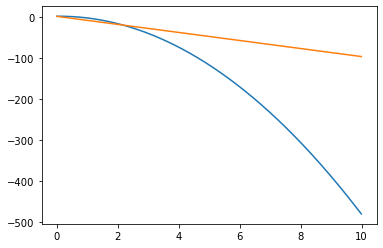

In [102]:
# Trying to set up a quick little integrator for projectile motion

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

x = 1
vx = 1 * np.cos(0.75)
dt = 0.01
t = np.arange(0, 10, dt)

def derivs(x, t):
    return np.array([x[1], -9.8])

currentPosition = odeint(derivs, np.array([x, vx]), t)

plt.plot(t, currentPosition)